In [2]:
# Importing Modules
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input  # Corrected MaxPooling2D spelling


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load Dataset


In [3]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace/'

In [4]:
image_paths = []
age_labels = []
gender_labels = []
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
df= pd.DataFrame()
df['image'],df['age'],df['gender']= image_paths,age_labels,gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [6]:
gender_dict = {0:'Male',1:'Female'}

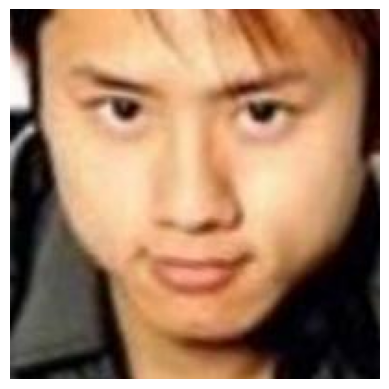

In [7]:
from PIL import Image 

img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);


<Axes: xlabel='age', ylabel='Density'>

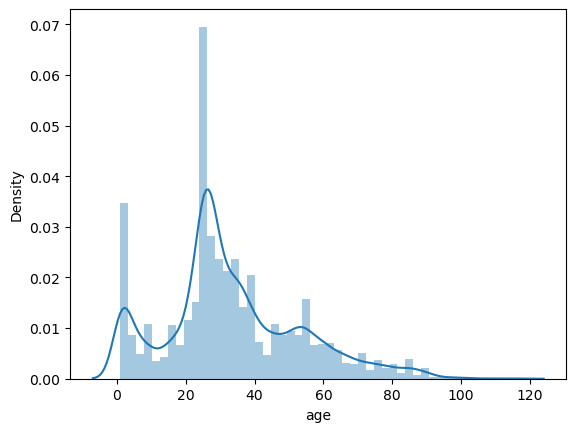

In [8]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

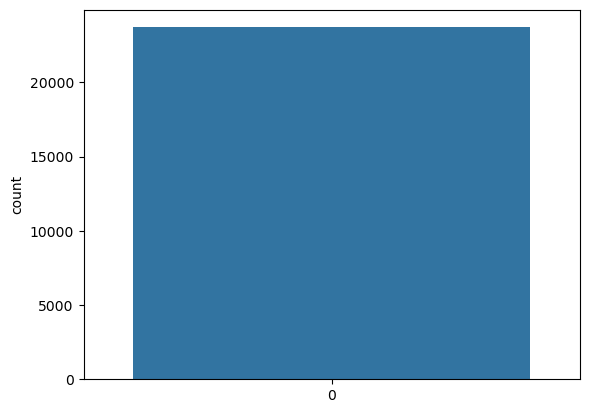

In [9]:
sns.countplot(df['gender'])

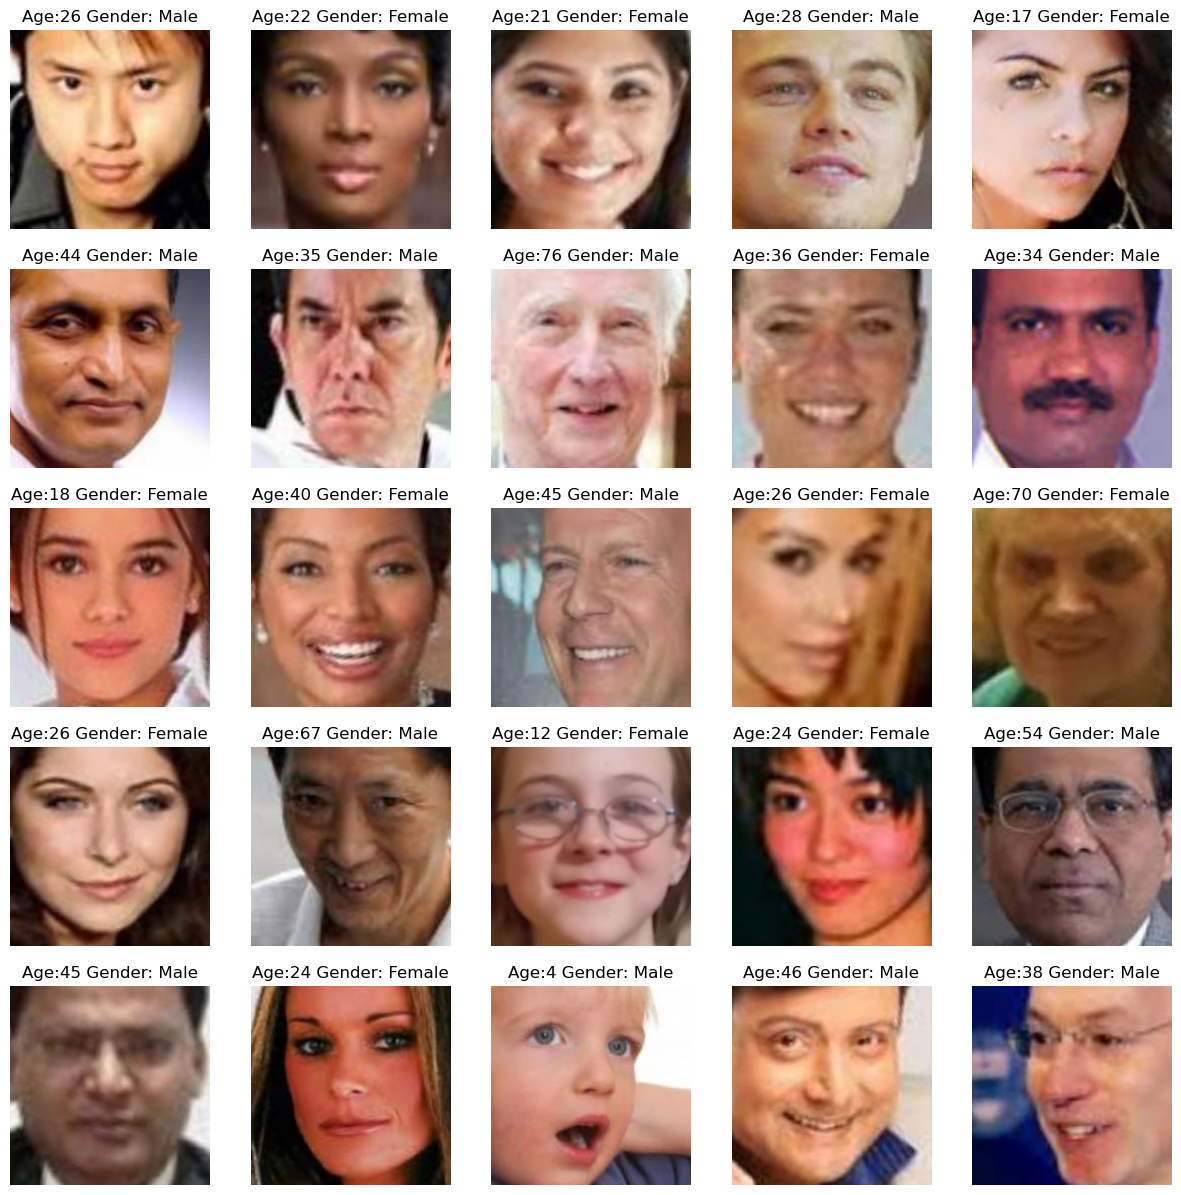

In [10]:
plt.figure(figsize=(15,15))
files = df.iloc[0:25]
for index,file,age,gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender: {gender_dict[gender]}")
    plt.axis('off')

**Feature Extraction**

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale=True)
        img = img.resize((128,128),Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),128,128,1)
    return features

In [12]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128,128,1)

**MODEL Creation**

In [17]:
inputs = Input(shape=input_shape)

# Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)  # 'relu' should be a string

# Create and compile the model
model = Model(inputs=[inputs], outputs=[output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

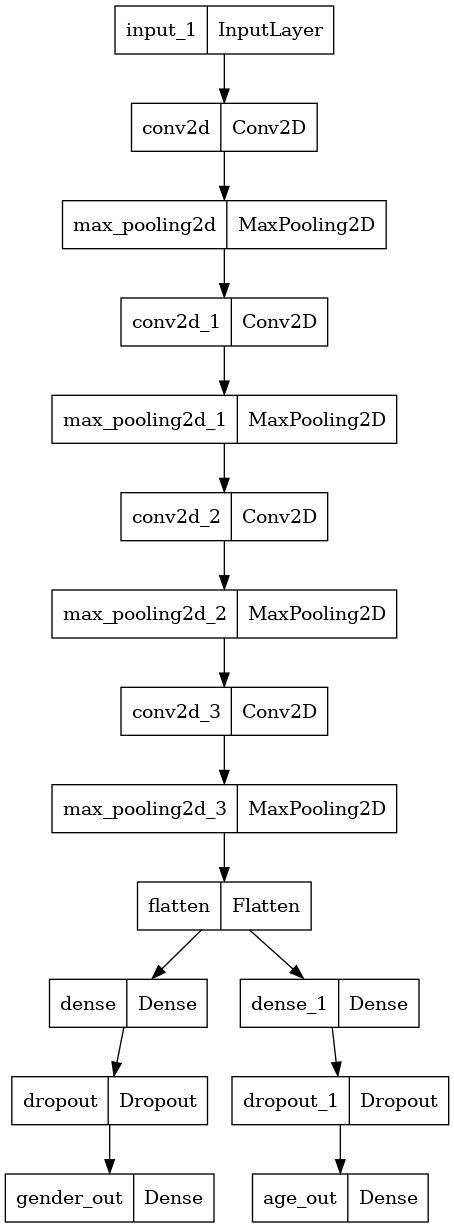

In [19]:
#Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
history  = model.fit(x=X,y=[y_gender,y_age], batch_size = 32, epochs=30,validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 444s 744ms/step - loss: 15.8670 - gender_out_loss: 0.6790 - age_out_loss: 15.1880 - gender_out_accuracy: 0.5525 - age_out_accuracy: 0.0475 - val_loss: 12.9406 - val_gender_out_loss: 0.5434 - val_age_out_loss: 12.3972 - val_gender_out_accuracy: 0.7252 - val_age_out_accuracy: 0.0430
Epoch 2/30
593/593 [==============================] - 429s 723ms/step - loss: 11.4321 - gender_out_loss: 0.4826 - age_out_loss: 10.9495 - gender_out_accuracy: 0.7689 - age_out_accuracy: 0.0349 - val_loss: 9.7064 - val_gender_out_loss: 0.4062 - val_age_out_loss: 9.3002 - val_gender_out_accuracy: 0.8155 - val_age_out_accuracy: 0.0245
Epoch 3/30
593/593 [==============================] - 430s 726ms/step - loss: 9.4828 - gender_out_loss: 0.3966 - age_out_loss: 9.0862 - gender_out_accuracy: 0.8200 - age_out_accuracy: 0.0237 - val_loss: 8.4461 - val_gender_out_loss: 0.3749 - val_age_out_loss: 8.0713 - val_gender_out_accuracy: 0.8256 - val_age_out_accuracy: 0.017

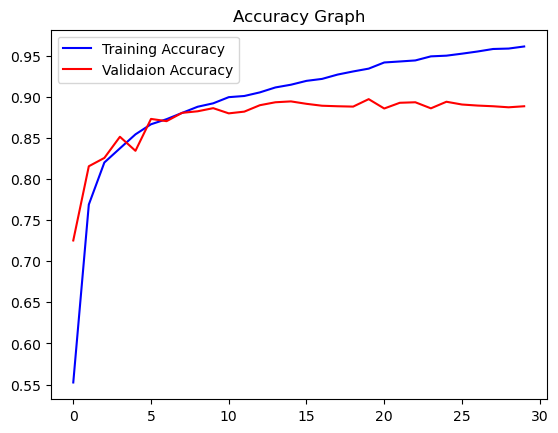

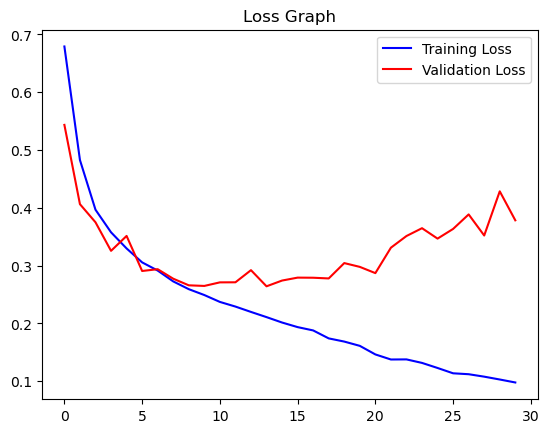

In [21]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label = 'Validaion Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()
loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']
plt.plot(epochs,loss,'b',label = 'Training Loss')
plt.plot(epochs,val_loss,'r',label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

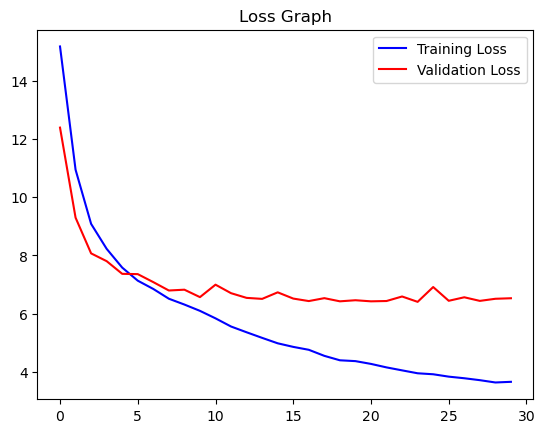

In [22]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(acc))

plt.plot(epochs,loss,'b',label = 'Training Loss')
plt.plot(epochs,val_loss,'r',label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 3
1/1 [==============================] - 0s 179ms/step
Predicted Gender: Female Predicted Age: 3


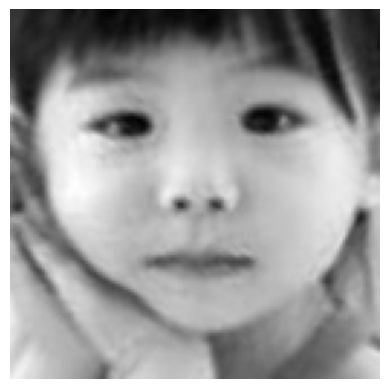

In [23]:
image_index = 100
print("Original Gender:",gender_dict[y_gender[image_index]],'Original Age:',y_age[image_index])
#PREDICTION from MODEL
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Male Original Age: 28
1/1 [==============================] - 0s 30ms/step
Predicted Gender: Male Predicted Age: 29


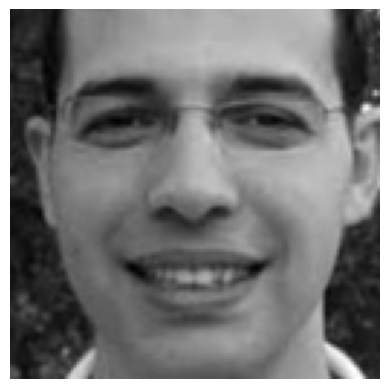

In [24]:
image_index = 3000
print("Original Gender:",gender_dict[y_gender[image_index]],'Original Age:',y_age[image_index])
#PREDICTION from MODEL
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128),cmap='gray');